In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import re
import sys,os
from wordcloud import WordCloud

from urllib.parse import urlparse

In [78]:
# for model building 
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from lightgbm import LGBMClassifier

In [79]:
df = pd.read_csv(r"C:\Users\Adarsha\Downloads\malicious_phish.csv")
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [80]:
df.head()    # displays first 5 tupples in the dataset

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [81]:
df.shape  #displays the total number of rows and columns in the dataset

(651191, 2)

In [82]:
df.type    

0           phishing
1             benign
2             benign
3         defacement
4         defacement
             ...    
651186      phishing
651187      phishing
651188      phishing
651189      phishing
651190      phishing
Name: type, Length: 651191, dtype: object

In [83]:
df.info()    #info of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [84]:
df.type.value_counts()     # counts the number of URLS for each class variables

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [85]:
# Describe the structure of the dataset
df.describe().T

,count,unique,top,freq
url,651191,641119,http://style.org.hc360.com/css/detail/mysite/s...,180
type,651191,4,benign,428103


In [86]:
#checking if the dataset contains any null values 
df.isna().sum()

url     0
type    0
dtype: int64

# Plotting the Word Cloud

In [10]:
df_benign = df[df.type == 'benign']
df_phishing = df[df.type == 'phishing']
df_malware = df[df.type == 'malware']
df_defacement = df[df.type == 'defacement']

In [31]:
# fig, axs = plt.sublplots(2, 2, figsize = (12, 14))
# wordcloud = WordCloud(width = 1600, height = 1000, colormap = 'Paired').generate(benign)
# axs[0].wordcloud

AttributeError: module 'matplotlib.pyplot' has no attribute 'sublplots'

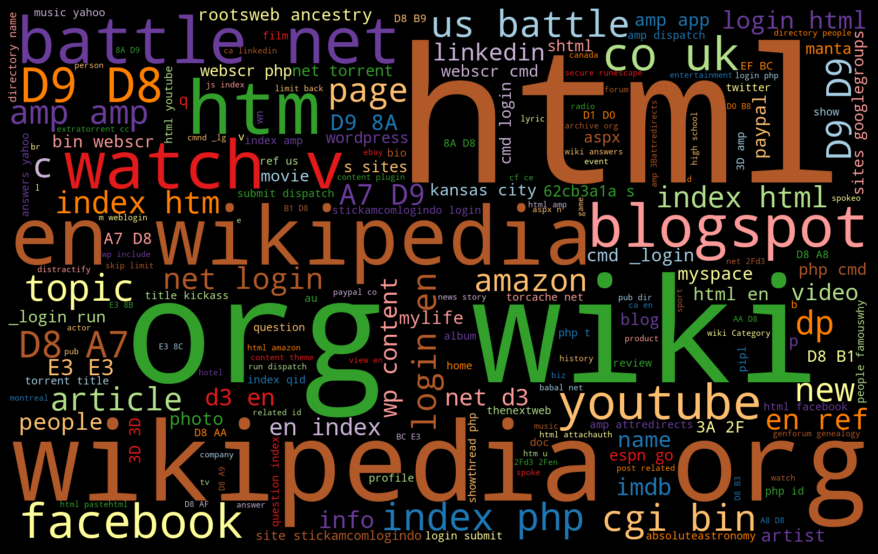

In [11]:
benign = " ".join (i for i in df_benign.url)
wordcloud = WordCloud(width = 1600, height = 1000, colormap = 'Paired').generate(benign)
plt.figure(figsize= (12, 14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad =0)
plt.show()


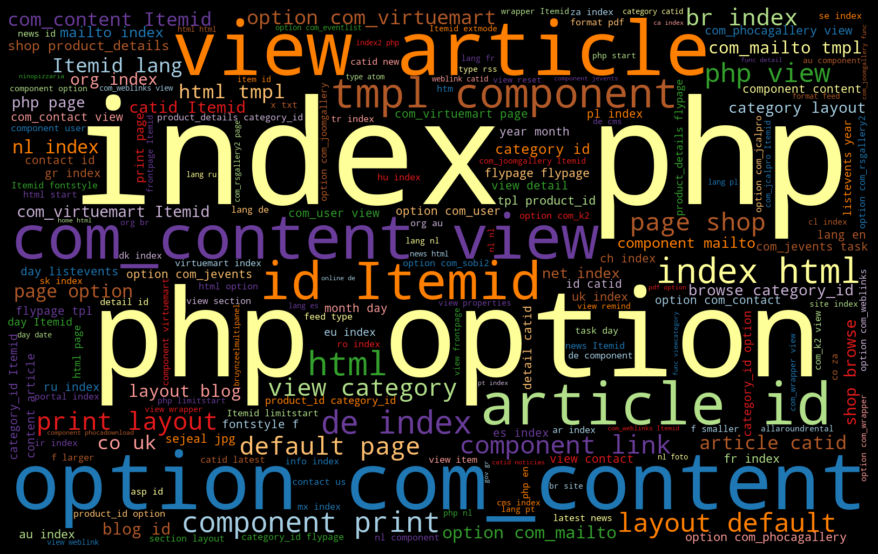

In [23]:
defacement = " ".join (i for i in df_defacement.url)
wordcloud = WordCloud(width = 1600, height = 1000, colormap = 'Paired').generate(defacement)
plt.figure(figsize= (12, 14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad =0)
plt.show()

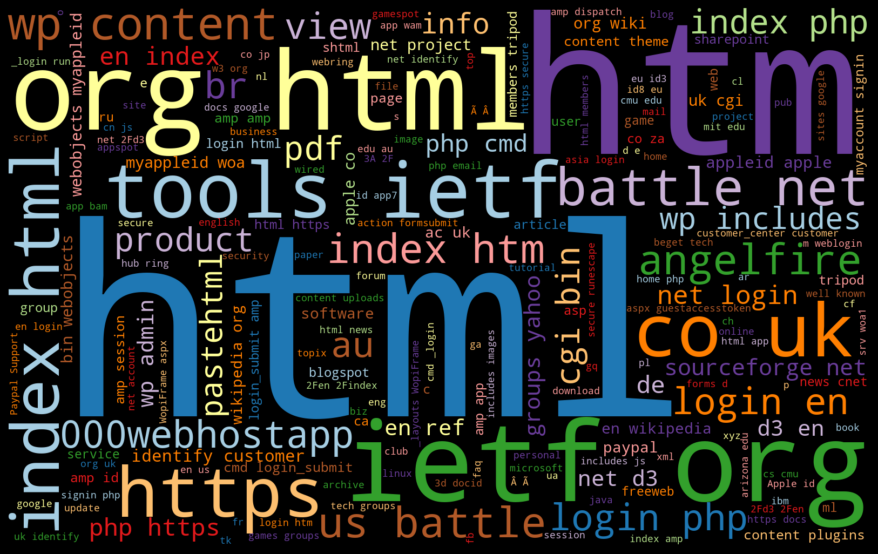

In [26]:
phishing = " ".join (i for i in df_phishing.url)
wordcloud = WordCloud(width = 1600, height = 1000, colormap = 'Paired').generate(phishing)
plt.figure(figsize= (12, 14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad =0)
plt.show()

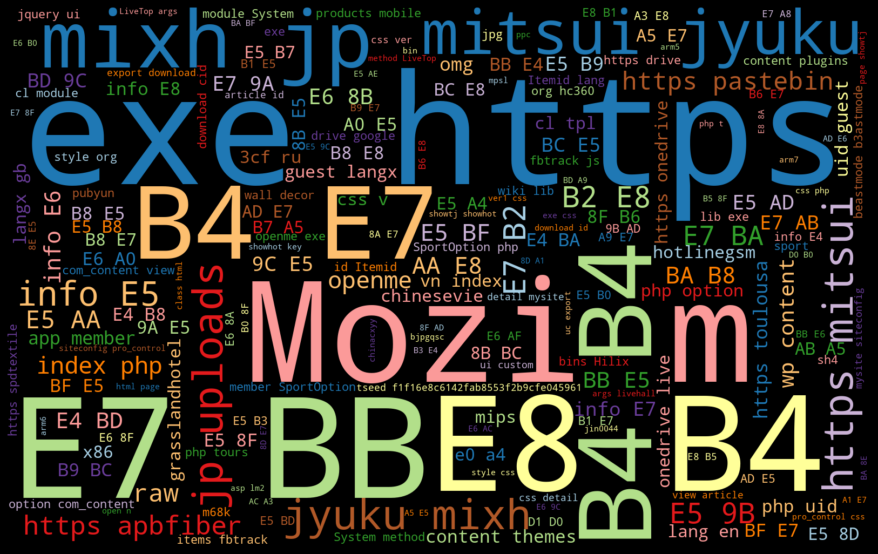

In [35]:
malware = " ".join (i for i in df_malware.url)
wordcloud = WordCloud(width = 1600, height = 1000, colormap = 'Paired').generate(malware)
plt.figure(figsize= (12, 14), facecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad =0)
plt.show()

## INFERENCES FROM WORDCLOUD

1. Benign URLs have frequent tokens like html, wikipedia, org, wiki, blogspot, youtube, etc
2. Defacement URLs are intented to modify the original website's code so it mostly contains the development terms such as index,
   php, option, com_content view, id Itemid, etc
3. Phishing URLs have frequent tokens like ietf, battle net, index html, tools, wp content view, etc 
   Also, they have high frequnecy of html, org, htm to mimick the original websites
4. Malware URLs have frequent tokens like Mozi, exe, BB, E7, E8, B4, mitsui, https, etc

# Deriving Features from the dataset (FEATURE ENGINEERING)

In [87]:
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)'# IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [88]:
# #checking if there is any abnormal URLs or not
# abnormal urls are basically those which contains some abnormal keywords: something that
# we don't see in the regular URLs

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0 
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [18]:
# pip install googlesearch-python

In [89]:
from googlesearch import search

In [90]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [91]:
def count_dot(url):
    url.count('.')
    return url.count('.')
df['count.'] = df['url'].apply(lambda i: count_dot(i))

In [92]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [93]:
df.tail()

,url,type,use_of_ip,abnormal_url,google_index,count.
651186,xbox360.ign.com/objects/850/850402.html,phishing,0,0,1,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,0,0,1,2
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,0,0,1,2
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,0,0,1,2
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing,0,0,1,2


In [94]:
# count of www
def count_www(url):
    url.count('www')
    return url.count('www')
df['count_www'] = df['url'].apply(lambda i: count_www(i))

# count of @
def count_atrate(url):
    url.count('@')
    return url.count('@')
df['count_@'] = df['url'].apply(lambda i: count_atrate(i))


#count of forward slash "/" i.e count of directories 
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir(/)'] = df['url'].apply(lambda i: no_of_dir(i))


#count of //
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
df['count_embed_domain(//)'] = df['url'].apply(lambda i: no_of_embed(i))



# for short URLs
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))


In [95]:
# count of application layer protocol (http/https)

def count_https(url):
    return url.count('https')
df['count_https'] = df['url'].apply(lambda i: count_https(i))


def count_http(url):
    return url.count('http')
df['count_http'] = df['url'].apply(lambda i: count_http(i))


In [96]:
# count of  symbols ( %, ?, -, =)

def count_per(url):
    return url.count('%')
df['count%'] = df['url'].apply(lambda i: count_per(i))


def count_ques(url):
    return url.count('?')
df['count?'] = df['url'].apply(lambda i: count_ques(i))


def count_hyphen(url):
    return url.count('-')
df['count -'] = df['url'].apply(lambda i: count_hyphen(i))


def count_equal(url):
    return url.count('=')
df['count='] =  df['url'].apply(lambda i : count_equal(i))



In [97]:
# length of URL possess good chance that the URLS are malicous 
def url_length(url):
    return len(str(url))
df['url_length'] = df['url']. apply(lambda i: url_length(i))


# HOSTNAME length 
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))


In [98]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count_www,count_@,count_dir(/),count_embed_domain(//),short_url,count_https,count_http,count%,count?,count -,count=,url_length,hostname_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23


In [28]:
# df.drop('count-', inplace=True, axis=1)

In [99]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count_www,count_@,count_dir(/),count_embed_domain(//),short_url,count_https,count_http,count%,count?,count -,count=,url_length,hostname_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23


In [100]:
# use of suspicous words like login, signin, bank, caccount, service, bonus, lucky, paypall in the urls generally show that 
# they are malicious

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr', url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


# digit count
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


#letter count
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

In [101]:
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count_www,count_@,count_dir(/),count_embed_domain(//),...,count_http,count%,count?,count -,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [102]:
# first pip install tld, we gotta install top level domain for the upcoming process..

# importing dependencies 
from urllib.parse import urlparse
from tld import get_tld
import os.path

def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain: TLD are .com, .edu, etc
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))



# we have to drop the topl level domain, since we have already extracted the necessary features that are required.
df = df.drop("tld",1)

C:\Users\Adarsha\AppData\Local\Temp/ipykernel_10044/1898941143.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("tld",1)


In [103]:
df

,url,type,use_of_ip,abnormal_url,google_index,count.,count_www,count_@,count_dir(/),count_embed_domain(//),...,count?,count -,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld_length
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,1,0,16,0,0,0,13,0,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,35,0,0,1,29,5,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,31,0,0,1,25,7,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,1,4,88,21,0,7,63,9,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,1,3,235,23,0,22,199,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,0,0,1,3,0,0,3,0,...,0,0,0,39,0,0,12,21,7,-1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,0,0,1,2,0,0,4,0,...,0,2,0,44,0,0,7,29,8,-1
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,0,0,1,2,1,0,4,0,...,0,0,0,42,0,0,3,33,7,-1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,0,0,1,2,0,0,2,0,...,0,0,0,45,0,0,0,36,4,-1


### This sums up our features engineering part. 
You may add features that are important/missing

In [104]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count_www', 'count_@', 'count_dir(/)', 'count_embed_domain(//)',
       'short_url', 'count_https', 'count_http', 'count%', 'count?', 'count -',
       'count=', 'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [35]:
# df['type'].value_count()

AttributeError: 'Series' object has no attribute 'value_count'

In [105]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

# EXPLORATORY DATA ANALYSIS (EDA)

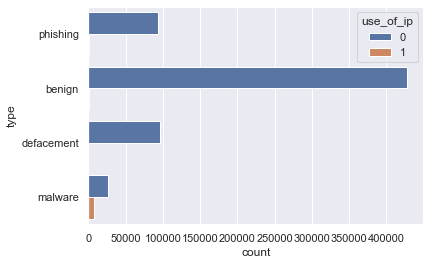

In [106]:
# impact of use of IP

import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

In [24]:
#!pip install ipyvizzu -q

In [30]:
# TRIED TO PUT ANIMATION IN THE CHART , SORRY I FUCKED UP :(


# from ipyvizzu import Chart, Data, Config

# data = Data()
# data.add_data_frame(df)

# chart = Chart(width='640px', height='360px', hue="use_of_ip")

# chart.animate(data)

# chart.animate(Config({"x": "Count", "y": "TYPE OF URL", "label": "Count","title":"USE OF IP "}))


TypeError: __init__() got an unexpected keyword argument 'hue'

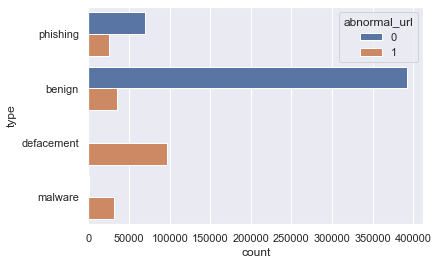

In [107]:
#impact of abnormal URL

sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

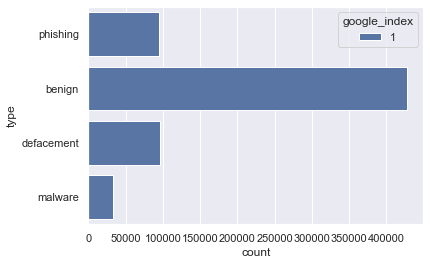

In [108]:
#impact of google index

sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

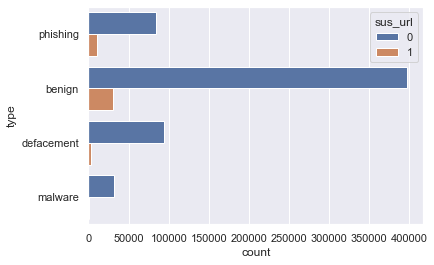

In [33]:
#impact of supicous url 

sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

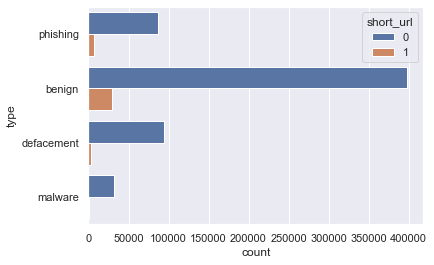

In [34]:
#impact of short urls

sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

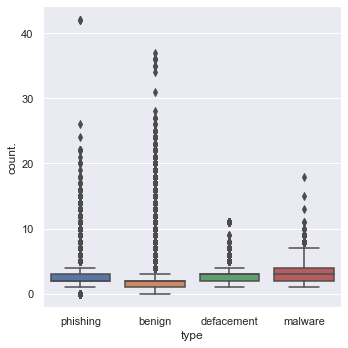

In [35]:
#count of dot(.)

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

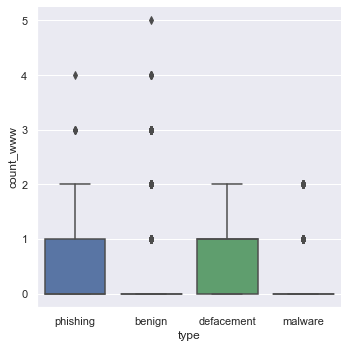

In [37]:
#count of www

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_www", kind="box", data=df)

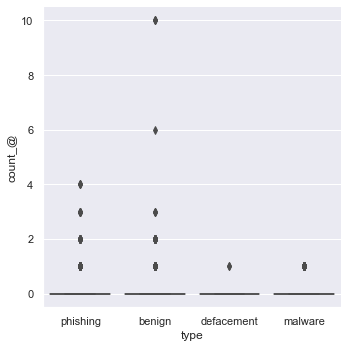

In [40]:
#count of @

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_@", kind="box", data=df)

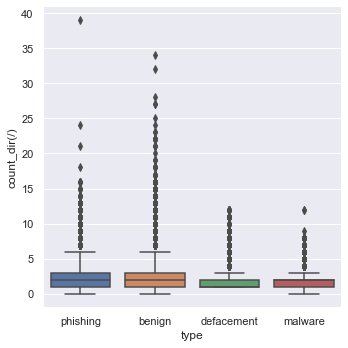

In [42]:
#count of count-dir

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir(/)", kind="box", data=df)

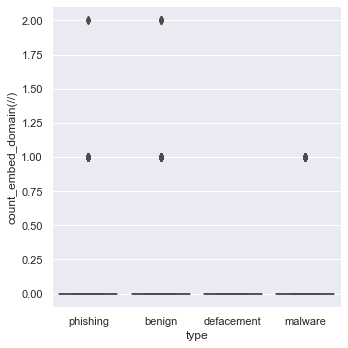

In [44]:
#count of count_embed-domain

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_embed_domain(//)", kind="box", data=df)

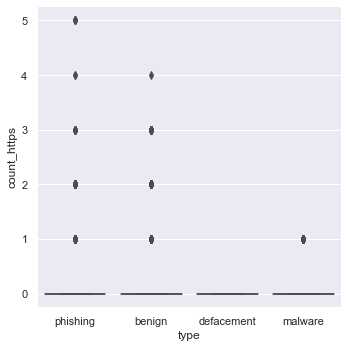

In [67]:
#count of https

sns.set(style="darkgrid")
# sns.set(rc={'figure.figsize':(1,1)})
ax = sns.catplot(x="type", y="count_https", kind="box", data=df)

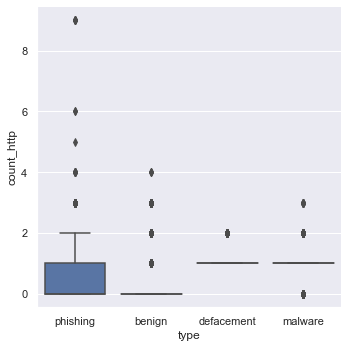

In [46]:
#count of http

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_http", kind="box", data=df)

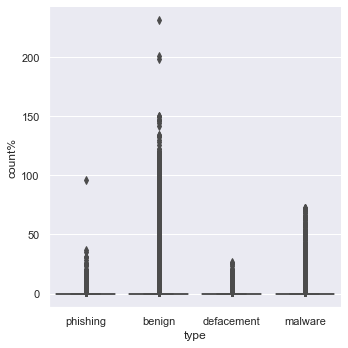

In [47]:
#count of %

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count%", kind="box", data=df)

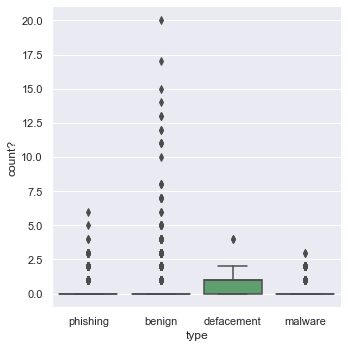

In [48]:
#count of ?

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count?", kind="box", data=df)

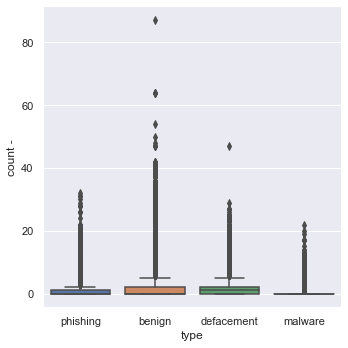

In [50]:
#count of -

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count -", kind="box", data=df)

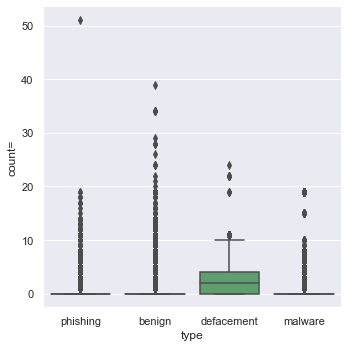

In [51]:
#count of =

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count=", kind="box", data=df)

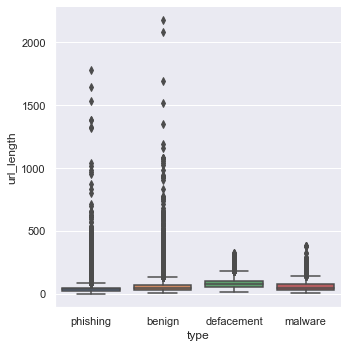

In [52]:
#URL length

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="url_length", kind="box", data=df)

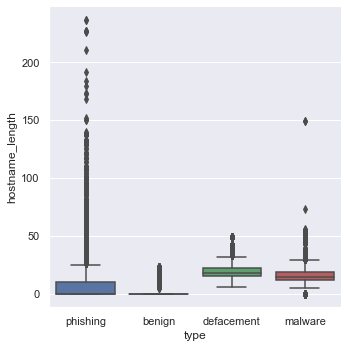

In [53]:
#hostname_length

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

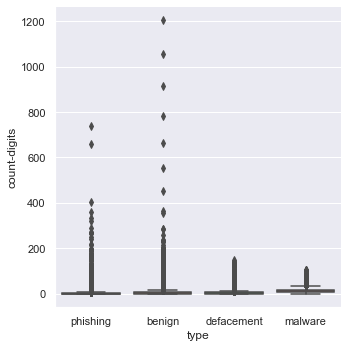

In [54]:
#count digits

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-digits", kind="box", data=df)

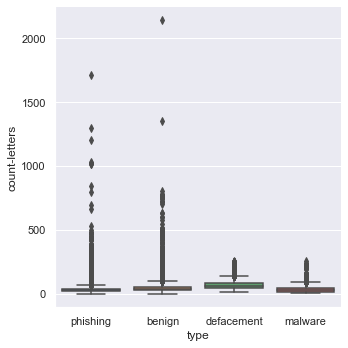

In [55]:
#count letters

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-letters", kind="box", data=df)

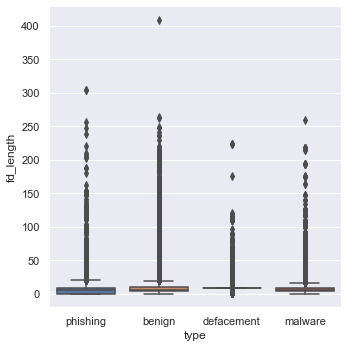

In [56]:
#first domain length

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

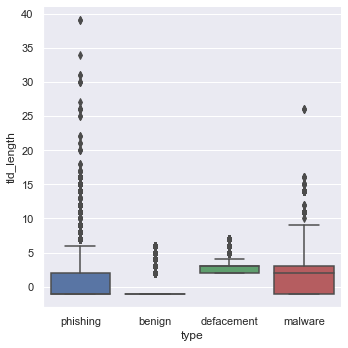

In [57]:
#top level domain length

sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

# INFERENCES

1. Distribution of benign class is comparatively higher than other classes
2. Only malware URLs seem to be using IP address in the URLs
3. Impact of abnormal keywords can be seen much frequntly with defacement URLs.
4. The google_index feature denotes if the URL is indexed in google search console or not. Here, all the URLs are google indexed and have a value of 1, so no point in keeping this column further, so lets DROP IT!

5. From the distribution of suspicious_urls, it is clear that benign URLs have highest distribution while phishing URLs have a second highest distribution. As suspicious URLs consist of transaction and payment-related keywords and generally genuine banking or payment-related URLs consist of such keywords that’s why benign URLs have the highest distribution.

6. Benign URLs are short as compared to other classes.
7. count@, embed_domain, count% have lesser impact on the model since their frequnecy of distribution is less so lets DROP IT!


## Dropping the redundant columns

In [109]:
df.drop('google_index', inplace=True, axis=1)

In [110]:
df.head()

,url,type,use_of_ip,abnormal_url,count.,count_www,count_@,count_dir(/),count_embed_domain(//),short_url,...,count?,count -,count=,url_length,hostname_length,sus_url,count-digits,count-letters,fd_length,tld_length
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0,0,...,0,1,0,16,0,0,0,13,0,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2,0,0,...,0,0,0,35,0,0,1,29,5,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3,0,0,...,0,0,0,31,0,0,1,25,7,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1,0,0,...,1,1,4,88,21,0,7,63,9,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1,0,0,...,1,1,3,235,23,0,22,199,9,3


In [111]:
df.drop('count_@', inplace=True, axis=1)
df.drop('count_embed_domain(//)', inplace=True, axis=1)
df.drop('count%', inplace=True, axis=1)


In [112]:
df.drop('url', inplace = True, axis = 1)

In [113]:
df.columns


Index(['type', 'use_of_ip', 'abnormal_url', 'count.', 'count_www',
       'count_dir(/)', 'short_url', 'count_https', 'count_http', 'count?',
       'count -', 'count=', 'url_length', 'hostname_length', 'sus_url',
       'count-digits', 'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

# TARGET ENCODING

In [114]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()


0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

# SEPERATE FEATURES AND TARGET VARIABLE

In [115]:
#Predictor Variables

X = df[['use_of_ip', 'abnormal_url', 'count.', 'count_www',
       'count_dir(/)', 'short_url', 'count_https', 'count_http', 'count?',
       'count -', 'count=', 'url_length', 'hostname_length', 'sus_url',
       'count-digits', 'count-letters', 'fd_length', 'tld_length']]

#Target Variable
y = df['type_code']

In [116]:
X.head()
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count_www', 'count_dir(/)',
       'short_url', 'count_https', 'count_http', 'count?', 'count -', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

# Train Test Split

In [117]:
# Training 80% and testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

# MODEL BUILDING (random forest) 

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train) #train

rf.score(X_test, y_test) #make prediction

y_pred_rf = rf.predict(X_test)

rf.score(X_test, y_test)

0.9661391749015272

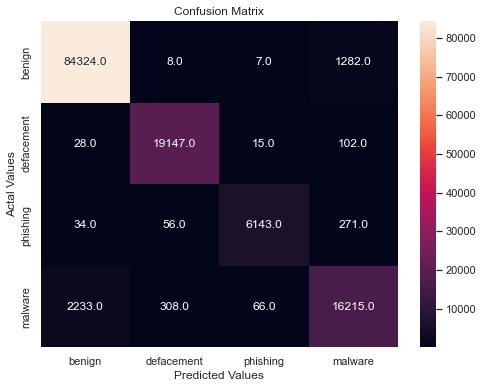

In [119]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<AxesSubplot:>

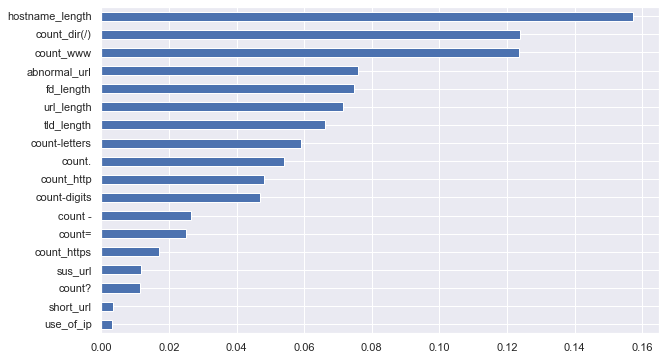

In [120]:
# weightage of features
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

# MAKING A DUMMY PREDICTION 

In [121]:
def main(url):
    
    status = []
    
    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
#     status.append(count_atrate(url))
    status.append(no_of_dir(url))
#     status.append(no_of_embed(url))
    
    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))
    
#     status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))
    
    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)
      
    status.append(tld_length(tld))
    
    
    

    return status

In [122]:

def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    

    pred = rf.predict(features_test)
    if int(pred[0]) == 0.0:
        
        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res

In [123]:
urls = ['https://twitter.com/i/lists/1424455802958409731']
for url in urls:
     print(get_prediction_from_url(url))

MALWARE


C:\Users\Adarsha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
